In [184]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import sparse

%matplotlib inline  # Подготовка окружения для лабораторной работы (графики и вычисления)


UsageError: unrecognized arguments: # Подготовка окружения для лабораторной работы (графики и вычисления)


# Лабораторная работа 2

### Методы решения СЛАУ

- Метод Гаусса с выбором главного элемента
- Метод $LU$-разложение
- Метод Якоби
- Метод Зейделя
- Метод верхней релаксации
- Метод градиентного спуска
- Метод минимальных невязок
- Стабилизированный метод бисопряженных градиентов

### Используемые нормы

#### Норма 1

$
\begin{align}
    ||\boldsymbol{u}||_1 = \max_{1 \leq i \leq n} |\boldsymbol{u}_i|,
\end{align}
$

$
\begin{align}
    ||\boldsymbol{A}||_1 = \max_{1 \leq i \leq n} \sum_{j = 1}^n |a_{ij}|.
\end{align}
$

#### Норма 2

$
\begin{align}
    ||\boldsymbol{u}||_2 = \sum_{j = 1}^n |\boldsymbol{u}_i|,
\end{align}
$

$
\begin{align}
    ||\boldsymbol{A}||_2 = \max_{1 \leq j \leq n} \sum_{i = 1}^n |a_{ij}|.
\end{align}
$

#### Норма 3

$
\begin{align}
    ||\boldsymbol{u}||_3 = \sqrt{(\boldsymbol{u}, \boldsymbol{u})},
\end{align}
$

$
\begin{align}
    ||\boldsymbol{A}||_3 = \sqrt{\max_{1 \leq i \leq n} \lambda_i (\boldsymbol{A^*} \cdot \boldsymbol{A})}.
\end{align}
$

### Решаемая СЛАУ

**б)** $n = 9, a_i, b_i, c_i, p_i, f_i$:

- $b_1 = 1, c_1 = 0, f_1 = 1$  
- $a_i = c_i = 1, b_i = -2, p_i = 2, f_i = \frac{2}{i^2}, i = 2, 3, ..., n$  
- $f_{n+1} = -\frac{n}{3}, p_1 = p_{n+1} = 1$

$
\begin{align}
\begin{cases}
b_1 x_1 + c_1 x_2 &= f_1 \\
a_2 x_1 + b_2 x_2 + c_2 x_3 &= f_2 \\
a_3 x_2 + b_3 x_3 + c_3 x_4 &= f_3 \\
\vdots & \vdots \\
a_n x_{n-1} + b_n x_n + c_n x_{n+1} &= f_n \\
p_1 x_1 + p_2 x_2 + \dots + p_n x_n + p_{n+1} x_{n+1} &= f_{n+1}
\end{cases}
\end{align}
$


In [185]:
# Класс для работы с разными нормами в СЛАУ
class Norm:
    def __init__(self, norm, name):
        self.norm = norm
        self.name = name


In [186]:
# Определение используемых норм для векторов и остаточных векторов
def norm_1(x):
    return np.linalg.norm(x, ord=np.inf)  # Норма ∞ (максимальный модуль компоненты)

def norm_2(x):
    return np.linalg.norm(x, ord=1)      # Норма 1 (сумма модулей)

def norm_3(x):
    return np.linalg.norm(x, ord=2)      # Норма 2 (евклидова)



### Генерация матрицы и вектора правой части

In [187]:
e = 1e-6

n = 9  # число переменных
# Параметры
a = np.ones(n+1)               # a_2..a_n = 1, a[0] не используется
b = np.array([1] + [-2]*(n-1)) # b_1=1, b_2..b_n=-2
c = np.array([0] + [1]*(n-1))  # c_1=0, c_2..c_n=1
f = np.array([1] + [2/i**2 for i in range(2, n+1)])  # правая часть для первых n уравнений
f_extra = -n/3  # дополнительное уравнение
p = np.array([1] + [2]*(n-1) + [1])  # коэффициенты для дополнительного уравнения

# Формируем полную матрицу (n+1)x(n+1)
A = np.zeros((n+1, n+1))
for i in range(n):
    if i > 0:
        A[i, i-1] = a[i+1]
    A[i, i] = b[i]
    if i < n-1:
        A[i, i+1] = c[i]
A[n, :] = p[:n+1]

f_full = np.append(f, f_extra)

norms = [Norm(norm_1, "Norm 1"), Norm(norm_2, "Norm 2"), Norm(norm_3, "Norm 3")]



### Метод Гаусса с выбором главного элемента

In [188]:

def swap_rows(A, f, i, j):
    A[[i, j]] = A[[j, i]]
    f[i], f[j] = f[j], f[i]

def swap_columns(A, pos, i, j):
    A = A.T
    A[[i, j]] = A[[j, i]]
    A = A.T
    pos[i], pos[j] = pos[j], pos[i]

def pivoting(A, f, pos, i, j, e, n):
    pivot = A[i, j]
    k_pivot, l_pivot = i, j
    for k in range(i, n):
        for l in range(j, n):
            if np.abs(A[k, l]) > np.abs(pivot):
                pivot = A[k, l]
                k_pivot, l_pivot = k, l
    if np.abs(pivot) < e:
        raise RuntimeError("Cannot find a pivot")
    if i != k_pivot:
        swap_rows(A, f, i, k_pivot)
    if j != l_pivot:
        swap_columns(A, pos, j, l_pivot)

def gauss(A_, f_, e, n):
    A = A_.copy()
    f = f_.copy()
    pos = np.arange(0, n, dtype=int)
    x = np.zeros(n, dtype=float)
    for k in range(n - 1):
        pivoting(A, f, pos, k, k, e, n)
        for i in range(k+1, n):
            t = A[i, k] / A[k, k]
            f[i] -= t * f[k]
            for j in range(k+1, n):
                A[i, j] -= t * A[k, j]
    x[n-1] = f[n-1] / A[n-1, n-1]
    for k in range(n-2, -1, -1):
        subtract = 0.0
        for j in range(k+1, n):
            subtract += A[k, j] * x[j]
        x[k] = (f[k] - subtract) / A[k, k]
    ans = np.zeros(n, dtype=float)
    for i in range(n):
        ans[pos[i]] = x[i]
    return ans

# Решаем систему с помощью Гаусса
x = gauss(A, f_full, e, n+1)

for norm in norms:
    print(f"Residual of Gaussian elimination in {norm.name}: {norm.norm(f_full-A.dot(x))}")


Residual of Gaussian elimination in Norm 1: 1.1102230246251565e-16
Residual of Gaussian elimination in Norm 2: 3.2612801348363973e-16
Residual of Gaussian elimination in Norm 3: 1.577740299643925e-16


### $LU$-разложение

In [189]:

def check_LU(A, e, n):
    for i in range(n):
        if np.abs(np.linalg.det(A[:i, :i])) < e:
            return False
    return True

def LU_decomposition(A_, e, n):
    A = A_.copy()
    for i in range(1, n):
        for k in range(i):
            A[i, k] /= A[k, k]
            for j in range(k+1, n):
                A[i, j] -= A[i, k] * A[k, j]

    L = np.eye(n, dtype=float)
    for i in range(n):
        for j in range(i):
            L[i, j] = A[i, j]

    U = np.zeros_like(A)
    for i in range(n):
        for j in range(i, n):
            U[i, j] = A[i, j]

    return L, U

def LU_solution(L_, U_, f_, n):
    L, U, f = L_.copy(), U_.copy(), f_.copy()
    x, y = np.zeros(n, dtype=float), np.zeros(n, dtype=float)

    for i in range(n):
        subtract = 0.0
        for k in range(i):
            subtract += L[i, k] * y[k]
        y[i] = f[i] - subtract

    for i in range(n-1, -1, -1):
        subtract = 0.0
        for k in range(i+1, n):
            subtract += U[i, k] * x[k]
        x[i] = (y[i] - subtract) / U[i, i]

    return x

# Решаем систему
if check_LU(A, e, n+1):
    L, U = LU_decomposition(A, e, n+1)
    x = LU_solution(L, U, f_full, n+1)

    for norm in norms:
        print(f"Residual of LU-decomposition in {norm.name}: {norm.norm(f_full-A.dot(x))}")


Residual of LU-decomposition in Norm 1: 6.938893903907228e-17
Residual of LU-decomposition in Norm 2: 2.0122792321330962e-16
Residual of LU-decomposition in Norm 3: 1.0500451862475693e-16


### Метод Якоби

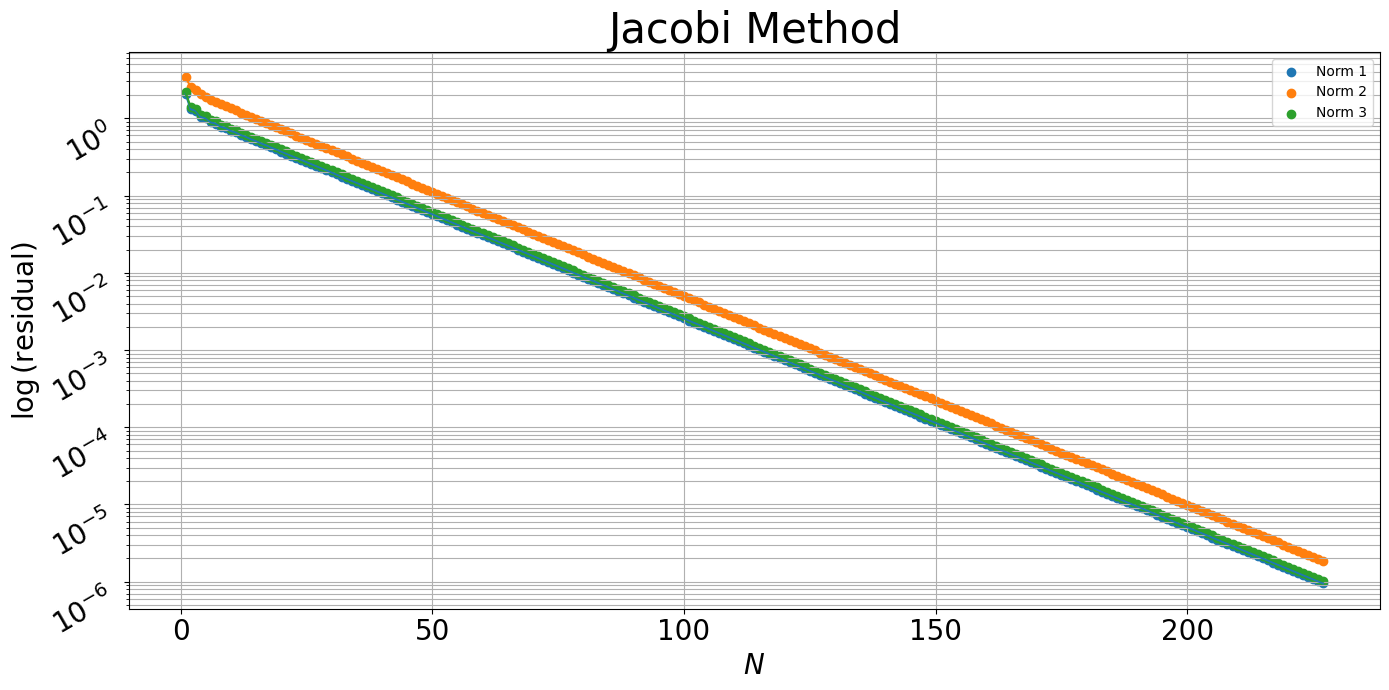

In [190]:
def jacobi(A, f, x_0, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            sigma = 0.0
            for j in range(n):
                if j != i:
                    sigma += A[i, j] * x[j]
            y[i] = (f[i] - sigma) / A[i, i]
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

# Начальное приближение
x_0 = np.ones(n+1)
x, residuals_1, residuals_2, residuals_3 = jacobi(A, f_full, x_0, e, n+1)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Jacobi Method", fontsize=30)
plt.yscale("log")
plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")
plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")
plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
plt.legend(loc="best")
plt.tight_layout()


### Метод Зейделя

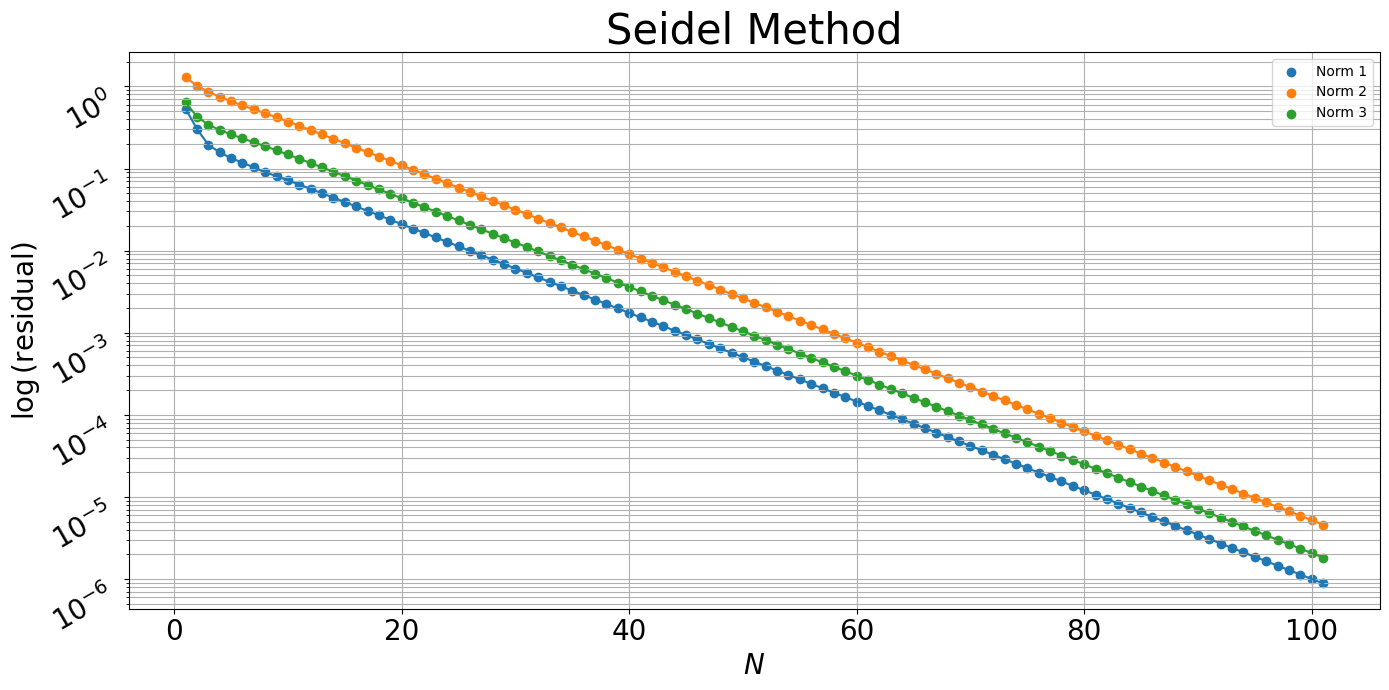

In [191]:
def seidel(A, f, x_0, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            sigma = 0.0
            for j in range(i):
                sigma += A[i, j] * y[j]
            for j in range(i+1, n):
                sigma += A[i, j] * x[j]

            y[i] = (f[i] - sigma) / A[i, i]
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

# Начальное приближение
x_0 = np.ones(n+1)
x, residuals_1, residuals_2, residuals_3 = seidel(A, f_full, x_0, e, n+1)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Seidel Method", fontsize=30)
plt.yscale("log")
plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")
plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")
plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
plt.legend(loc="best")
plt.tight_layout()


###  Метод верхней релаксации

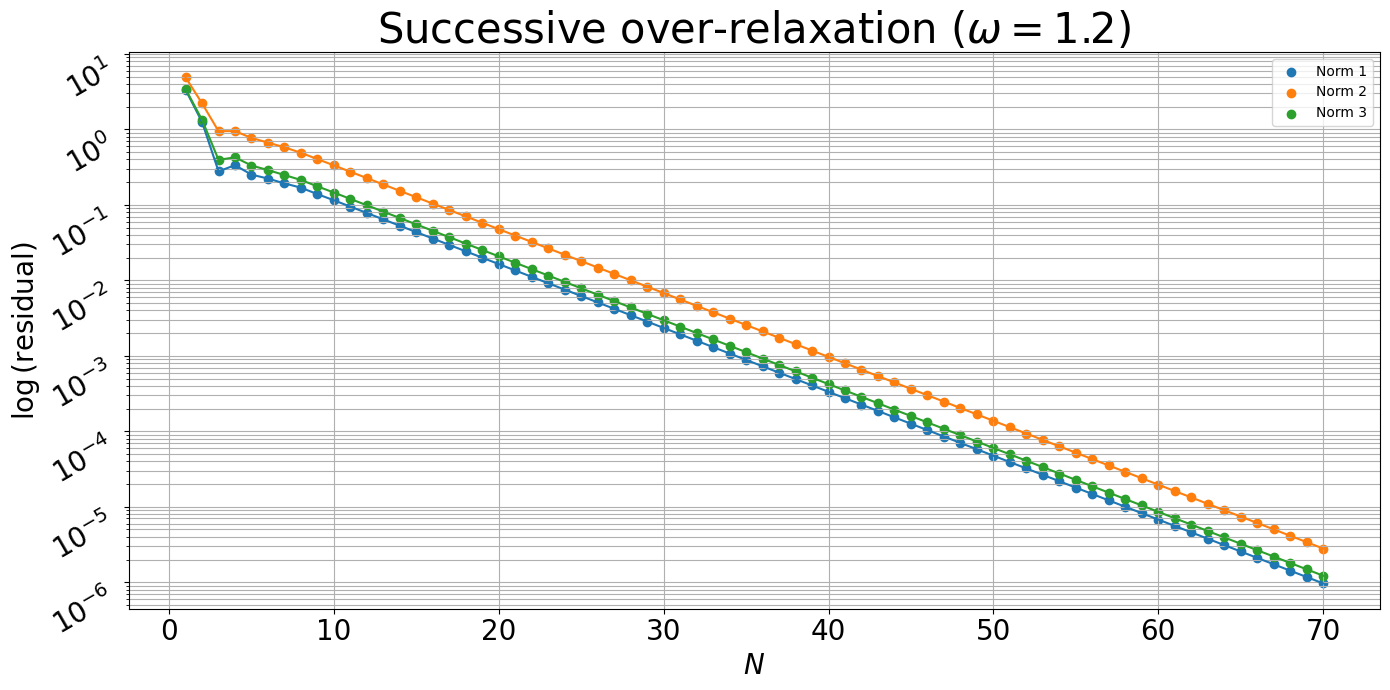

In [192]:
def SOR(A, f, x_0, w, e, n):
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        y = np.zeros(n)
        for i in range(n):
            sigma = 0.0
            for j in range(i):
                sigma += A[i, j] * y[j]
            for j in range(i+1, n):
                sigma += A[i, j] * x[j]

            sigma = (f[i] - sigma) / A[i, i]
            y[i] = x[i] + w * (sigma - x[i])
        x = y

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

# Параметры
w = 1.2
x_0 = np.ones(n+1)
x, residuals_1, residuals_2, residuals_3 = SOR(A, f_full, x_0, w, e, n+1)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Successive over-relaxation ($\\omega = 1.2$)", fontsize=30)
plt.yscale("log")
plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")
plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")
plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
plt.legend(loc="best")
plt.tight_layout()


### Метод наискорейшего спуска

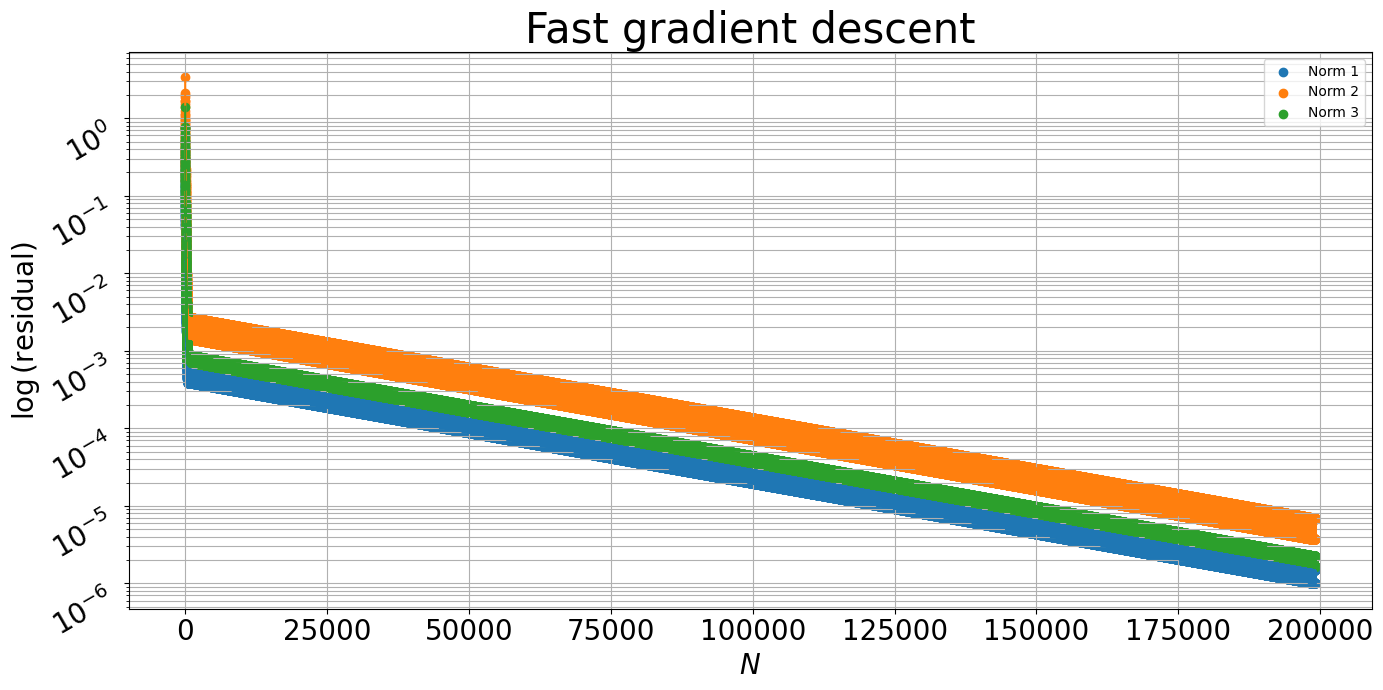

In [193]:
def FGD(A_, f_, x_0, e):
    A = A_.T @ A_
    f = A_.T.dot(f_)
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        r = A.dot(x) - f
        tau = r.dot(r) / (A.dot(r)).dot(r)
        x -= tau * r

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

# Начальное приближение
x_0 = np.ones(n+1)
x, residuals_1, residuals_2, residuals_3 = FGD(A, f_full, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Fast gradient descent", fontsize=30)
plt.yscale("log")
plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")
plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")
plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
plt.legend(loc="best")
plt.tight_layout()


### Метод минимальных невязок

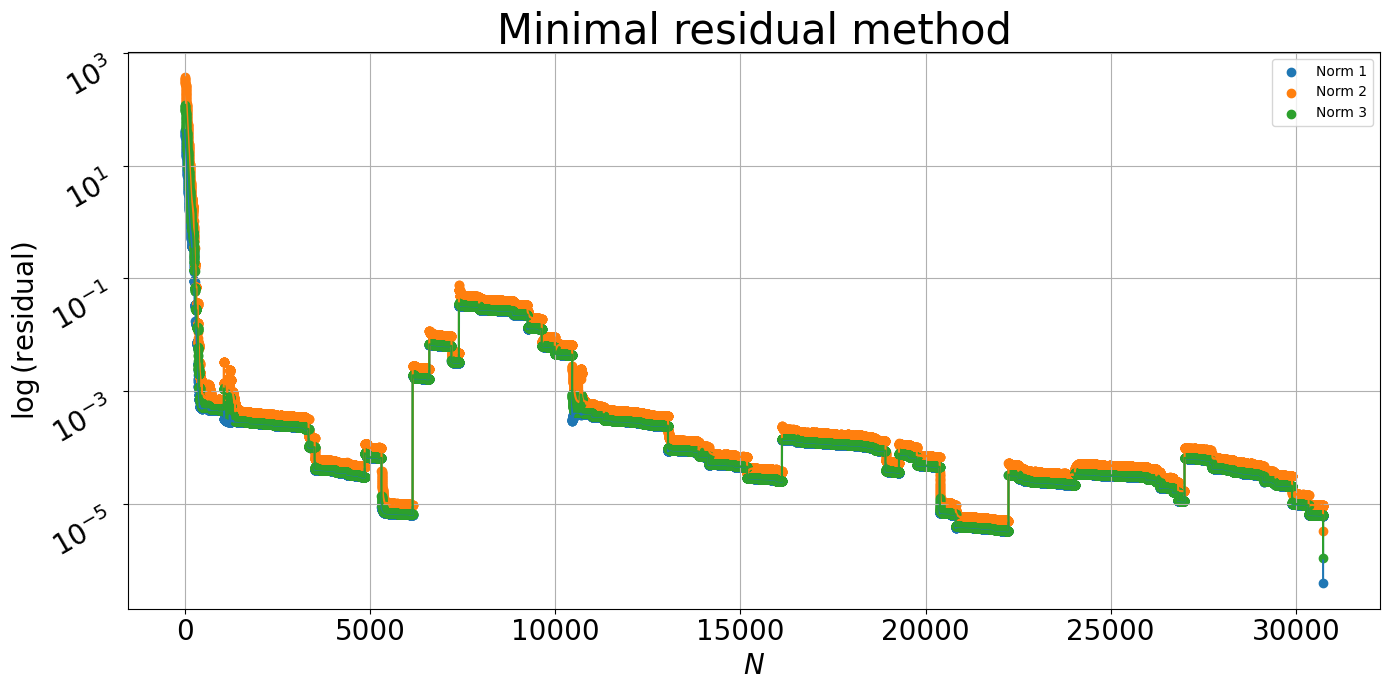

In [194]:
def MRM(A_, f_, x_0, e):
    A = A_.T @ A_
    f = A_.T.dot(f_)
    x = x_0.copy()
    residuals_1, residuals_2, residuals_3 = [], [], []

    while(min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e):
        r = A.dot(x) - f
        tau = (A.dot(r)).dot(r) / (A.dot(A.dot(r))).dot(A.dot(r))
        x -= tau * r

        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))

    return x, residuals_1, residuals_2, residuals_3

# Начальное приближение
x_0 = np.ones(n+1)
x, residuals_1, residuals_2, residuals_3 = MRM(A, f_full, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("Minimal residual method", fontsize=30)
plt.yscale("log")
plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")
plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")
plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
plt.legend(loc="best")
plt.tight_layout()


### Стабилизированный метод бисопряжённых градиентов

Количество итераций: 1
Последняя невязка: 2.778e-15


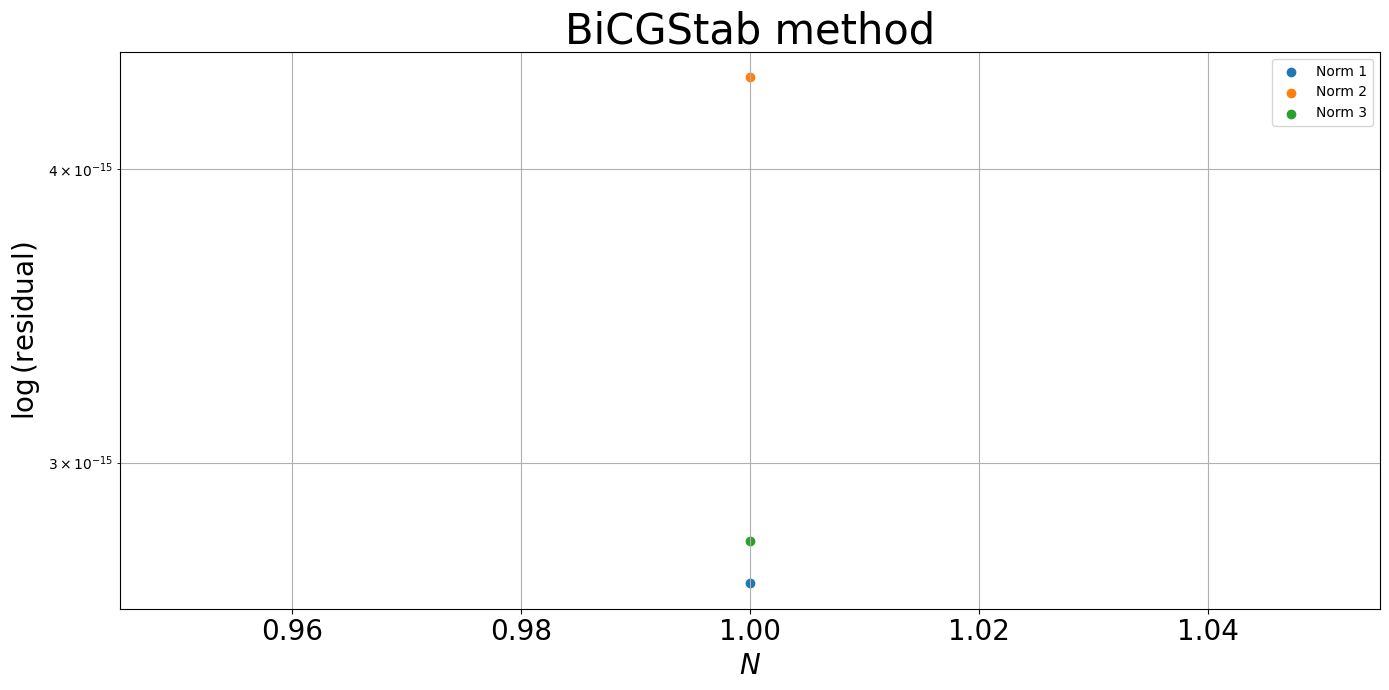

In [195]:
def precondition(A):
    return sparse.linalg.spilu(A.tocsc())

def BiCGStab(A_, f_, x_0, e):
    A = sparse.csr_matrix(A_)  # используем разреженный формат для spilu
    f = f_.copy()
    x = x_0.copy()
    M = precondition(A)
    residuals_1, residuals_2, residuals_3 = [], [], []

    r_0 = f - A.dot(x)
    r = r_0.copy()
    rho_prev = alpha = omega = 1.0
    v = p = np.zeros_like(x)
    iteration = 0  # счетчик итераций


    while min(norm_1(f - A.dot(x)), norm_2(f - A.dot(x)), norm_3(f - A.dot(x))) > e:
        iteration += 1
        rho = np.dot(r_0, r)
        if abs(rho) < e:
            raise RuntimeError("BiCGStab cannot solve the system")
        if rho_prev == 1.0:
            p = r.copy()
        else:
            beta = (rho/rho_prev)*(alpha/omega)
            p = r + beta*(p - omega*v)

        p_ = M.solve(p)
        v = A.dot(p_)
        alpha = rho / np.dot(r_0, v)
        s = r - alpha * v

        if norm_3(s)/norm_3(r_0) < e:
            x += alpha * p_
            residuals_1.append(norm_1(f - A.dot(x)))
            residuals_2.append(norm_2(f - A.dot(x)))
            residuals_3.append(norm_3(f - A.dot(x)))
            break

        s_ = M.solve(s)
        t = A.dot(s_)
        omega = np.dot(t, s) / np.dot(t, t)
        x += alpha * p_ + omega * s_
        r = s - omega * t

        rho_prev = rho
        residuals_1.append(norm_1(f - A.dot(x)))
        residuals_2.append(norm_2(f - A.dot(x)))
        residuals_3.append(norm_3(f - A.dot(x)))
    print(f"Количество итераций: {iteration}")
    print(f"Последняя невязка: {norm_3(f - A.dot(x)):.3e}")
    return x, residuals_1, residuals_2, residuals_3

# начальное приближение
x_0 = np.ones(n+1)
x, residuals_1, residuals_2, residuals_3 = BiCGStab(A, f_full, x_0, e)
residuals = np.array([np.array(residuals_1), np.array(residuals_2), np.array(residuals_3)])

iterations = np.arange(1, residuals[0].size + 1)

plt.figure(figsize=[14, 7])
plt.title("BiCGStab method", fontsize=30)
plt.yscale("log")
plt.xlabel('$N$', fontsize=20)
plt.xticks(fontsize=20, ha="center", va="top")
plt.ylabel("$\\log{(\\text{residual})}$", fontsize=20)
plt.yticks(fontsize=20, rotation=30, ha="right", va="top")
plt.grid(which="both")

for residual, norm in zip(residuals, norms):
    plt.scatter(iterations, residual, label=norm.name)
    plt.plot(iterations, residual)
plt.legend(loc="best")
plt.tight_layout()
